# Exercise 1 - M3

In this assignment, you will deepen your understanding of feature engineering, data preprocessing, and neural network modeling in PyTorch. While we suggest using a house pricing dataset for illustrative purposes, you are free to choose any dataset of interest. Your goal is to build a neural network that can handle either:

```
1. Preprocess and engineer features from your chosen dataset.
2. Build, train, and evaluate at least one neural network architecture in PyTorch:
  *   MLP if you have cross-sectional data.
  *   RNN if you have time-series/sequential data.
3. Experiment with hyperparameters (e.g., number of layers/neurons, activation functions, learning rates, epochs, etc.).
4. Evaluate and discuss your results, using appropriate performance metrics.

```


## 1. Preprocess and engineer features from your chosen dataset

I will be using recent 5 years of stock prices of NVIDIA as our dataset which will be pulled from yFinance. To train the DL model, I will be using a RNN, as the stock prices from the last 5 years are sequential data.

Let's implement the RNN using PyTorch!

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [2]:
# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('NVDA', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close
Ticker,NVDA
Date,
2020-02-10,6.546803
2020-02-11,6.669290
2020-02-12,6.785054
2020-02-13,6.741238
2020-02-14,7.214505
...,...
2025-02-03,116.660004
2025-02-04,118.650002


In [4]:
# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
df.dropna(inplace=True)

In [5]:
# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [6]:
# Preview the dataframe
df

Price,Close,lag_5,rolling_mean_10,rolling_sd_10
Ticker,NVDA,,,
Date,,,,
2020-02-24,6.803477,7.214505,7.098466,0.451153
2020-02-25,6.523900,7.383296,7.096175,0.454311
2020-02-26,6.663316,7.834654,7.095578,0.454939
2020-02-27,6.292397,7.685282,7.046312,0.515011
2020-02-28,6.727585,7.321058,7.044947,0.515927
...,...,...,...,...
2025-02-03,116.660004,118.419998,131.023001,12.174614
2025-02-04,118.650002,128.990005,128.805001,12.209785


## 2. Build, train, and evaluate at least one neural network architecture in PyTorch

In [7]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

In [8]:
# Step 5: Prepare Data for RNN Input
#Creates the specific tabular data with 3 inputs and 1 labelled variable.
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5 #We choose 5 as our timesteps, as there are no action in weekends
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
# Step 6: Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define the loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate set to 0.001

In [10]:
# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/20, Train Loss: 0.000163, Valid Loss: 0.017676
Epoch 4/20, Train Loss: 0.000219, Valid Loss: 0.016352
Epoch 6/20, Train Loss: 0.000264, Valid Loss: 0.015416
Epoch 8/20, Train Loss: 0.000252, Valid Loss: 0.012872
Epoch 10/20, Train Loss: 0.000201, Valid Loss: 0.010583
Epoch 12/20, Train Loss: 0.000172, Valid Loss: 0.009338
Epoch 14/20, Train Loss: 0.000139, Valid Loss: 0.008544
Epoch 16/20, Train Loss: 0.000147, Valid Loss: 0.008631
Epoch 18/20, Train Loss: 0.000126, Valid Loss: 0.007924
Epoch 20/20, Train Loss: 0.000103, Valid Loss: 0.007628


In [11]:
# Step 8: Evaluate the Model on testing dataset
# Evaluate on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

# Compute MSE for the test set
mse = mean_squared_error(test_actuals, test_preds)
print(f'Mean Squared Error on Test Set: {mse:.6f}')

Mean Squared Error on Test Set: 0.143380


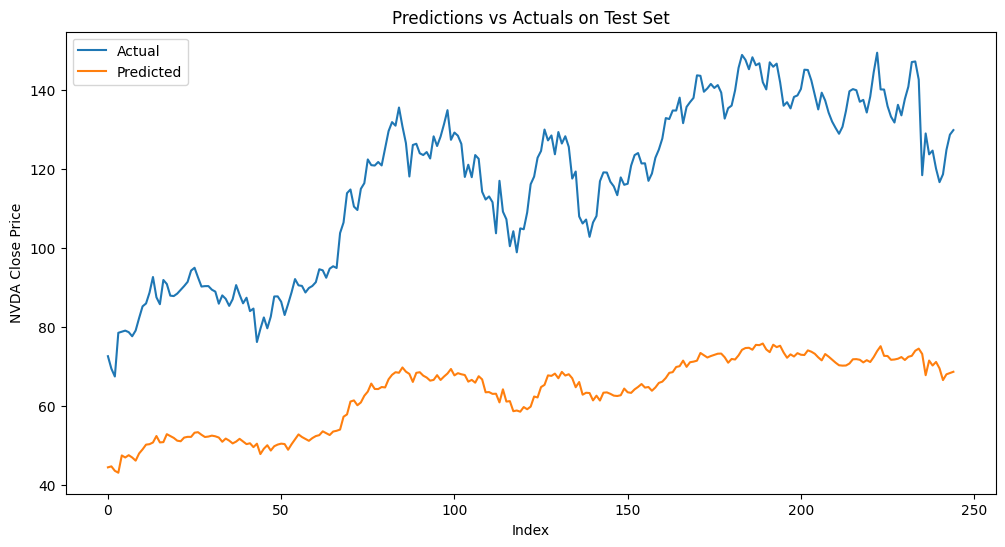

In [12]:
# Step 9: Denormalize and Visualize Predictions
# Since we have multiple features, we need to only inverse transform the target variable
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

# Denormalize the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

## 3. Experiment with hyperparameters (e.g., number of layers/neurons, activation functions, learning rates, epochs, etc.)

### Let's try decreasing the learning rate from 0.001 to 0.0005

In [13]:
# Step 1: Load and Preprocess Data for Second Model
end_date2 = pd.Timestamp.today()
start_date2 = end_date2 - pd.DateOffset(years=5)  # Last 5 years
df2 = yf.download('NVDA', start=start_date2, end=end_date2)
df2 = df2[['Close']]
df2 = df2.sort_index()

# Step 2: Create Lag and Rolling Features for Second Model
df2['lag_5'] = df2['Close'].shift(5)
df2['rolling_mean_10'] = df2['Close'].rolling(window=10).mean()
df2['rolling_sd_10'] = df2['Close'].rolling(window=10).std()
df2.dropna(inplace=True)

# Step 3: Normalize the Data for Second Model
scaler2 = MinMaxScaler()
data_scaled2 = scaler2.fit_transform(df2)

# Step 4: Split Data into Training and Testing Sets for Second Model
train_size2 = int(len(data_scaled2) * 0.8)
train_data2 = data_scaled2[:train_size2]
test_data2 = data_scaled2[train_size2:]

# Further split the training data into training and validation sets
train_valid_size2 = int(len(train_data2) * 0.8)
train_data_final2 = train_data2[:train_valid_size2]
valid_data2 = train_data2[train_valid_size2:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps2 = 5
n_features2 = data_scaled2.shape[1]
target_column_index2 = 0

# Create sequences for training, validation, and testing for Second Model
X_train2, y_train2 = create_sequences_multivariate(train_data_final2, n_timesteps2, target_column_index2)
X_valid2, y_valid2 = create_sequences_multivariate(valid_data2, n_timesteps2, target_column_index2)
X_test2, y_test2 = create_sequences_multivariate(test_data2, n_timesteps2, target_column_index2)

# Convert to tensors
X_train2 = torch.tensor(X_train2, dtype=torch.float32)
y_train2 = torch.tensor(y_train2, dtype=torch.float32)

X_valid2 = torch.tensor(X_valid2, dtype=torch.float32)
y_valid2 = torch.tensor(y_valid2, dtype=torch.float32)

X_test2 = torch.tensor(X_test2, dtype=torch.float32)
y_test2 = torch.tensor(y_test2, dtype=torch.float32)

# Create DataLoaders for Second Model
train_dataset2 = TensorDataset(X_train2, y_train2)
valid_dataset2 = TensorDataset(X_valid2, y_valid2)
test_dataset2 = TensorDataset(X_test2, y_test2)

train_loader2 = DataLoader(train_dataset2, batch_size=1, shuffle=False)
valid_loader2 = DataLoader(valid_dataset2, batch_size=1, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=1, shuffle=False)

# Step 6: Define the Second RNN Model
class RNNModel2(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel2, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model2 = RNNModel2(input_size=n_features2, hidden_size=50, output_size=1)

# Define loss function and optimizer for Second Model
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)

# Step 7: Train the Second Model
device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device2)

num_epochs2 = 20
train_losses2 = []
valid_losses2 = []

for epoch in range(num_epochs2):
    model2.train()
    train_loss2 = 0
    for inputs, targets in train_loader2:
        inputs = inputs.to(device2)
        targets = targets.to(device2)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss2 = criterion2(outputs.squeeze(), targets)
        loss2.backward()
        optimizer2.step()
        train_loss2 += loss2.item() * inputs.size(0)
    train_loss2 /= len(train_loader2.dataset)
    train_losses2.append(train_loss2)

    # Evaluate on validation set
    model2.eval()
    valid_loss2 = 0
    with torch.no_grad():
        for inputs, targets in valid_loader2:
            inputs = inputs.to(device2)
            targets = targets.to(device2)
            outputs = model2(inputs)
            loss2 = criterion2(outputs.squeeze(), targets)
            valid_loss2 += loss2.item() * inputs.size(0)
    valid_loss2 /= len(valid_loader2.dataset)
    valid_losses2.append(valid_loss2)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs2}, Train Loss: {train_loss2:.6f}, Valid Loss: {valid_loss2:.6f}')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/20, Train Loss: 0.000191, Valid Loss: 0.016083
Epoch 4/20, Train Loss: 0.000256, Valid Loss: 0.011720
Epoch 6/20, Train Loss: 0.000251, Valid Loss: 0.009284
Epoch 8/20, Train Loss: 0.000183, Valid Loss: 0.006642
Epoch 10/20, Train Loss: 0.000131, Valid Loss: 0.004825
Epoch 12/20, Train Loss: 0.000098, Valid Loss: 0.004160
Epoch 14/20, Train Loss: 0.000090, Valid Loss: 0.004379
Epoch 16/20, Train Loss: 0.000083, Valid Loss: 0.003635
Epoch 18/20, Train Loss: 0.000078, Valid Loss: 0.003722
Epoch 20/20, Train Loss: 0.000073, Valid Loss: 0.003513


In [14]:
# Step 8: Evaluate the Second Model
model2.eval()
with torch.no_grad():
    test_preds2 = model2(X_test2.to(device2)).cpu().numpy()
    test_actuals2 = y_test2.numpy()

# Compute MSE for the test set
mse2 = mean_squared_error(test_actuals2, test_preds2)
print(f'Mean Squared Error on Test Set: {mse2:.6f}')

Mean Squared Error on Test Set: 0.065252


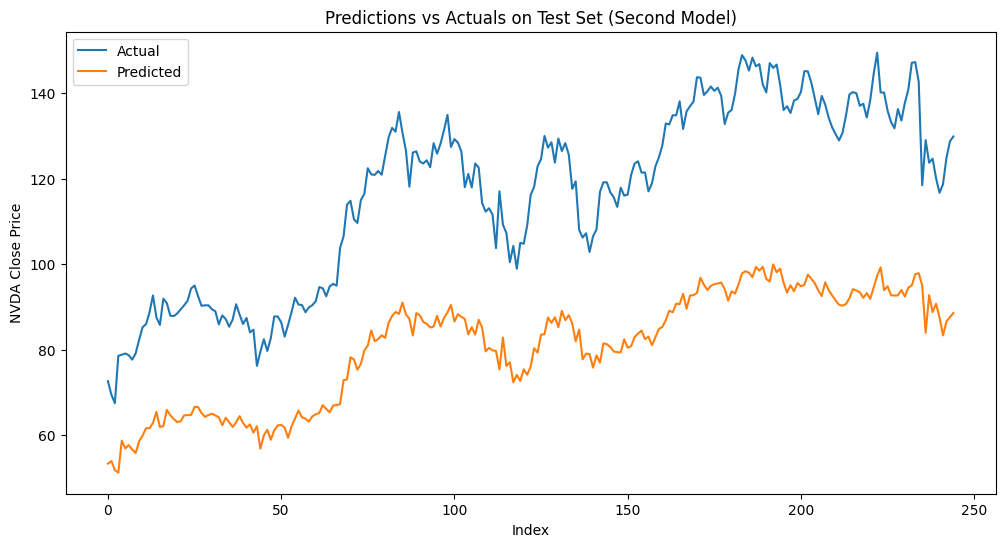

In [15]:
# Step 9: Denormalize and Visualize Predictions for Second Model
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm2 = denormalize(test_preds2, scaler2, target_column_index2)
test_actuals_denorm2 = denormalize(test_actuals2.reshape(-1, 1), scaler2, target_column_index2)

# Plot predictions vs actuals for Second Model
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm2, label='Actual')
plt.plot(test_preds_denorm2, label='Predicted')
plt.title('Predictions vs Actuals on Test Set (Second Model)')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

### Let's try increasing the number of epochs to 100

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load and Preprocess Data for Third Model
end_date3 = pd.Timestamp.today()
start_date3 = end_date3 - pd.DateOffset(years=5)  # Last 5 years
df3 = yf.download('NVDA', start=start_date3, end=end_date3)
df3 = df3[['Close']]
df3 = df3.sort_index()

# Step 2: Create Lag and Rolling Features for Third Model
df3['lag_5'] = df3['Close'].shift(5)
df3['rolling_mean_10'] = df3['Close'].rolling(window=10).mean()
df3['rolling_sd_10'] = df3['Close'].rolling(window=10).std()
df3.dropna(inplace=True)

# Step 3: Normalize the Data for Third Model
scaler3 = MinMaxScaler()
data_scaled3 = scaler3.fit_transform(df3)

# Step 4: Split Data into Training and Testing Sets for Third Model
train_size3 = int(len(data_scaled3) * 0.8)
train_data3 = data_scaled3[:train_size3]
test_data3 = data_scaled3[train_size3:]

# Further split the training data into training and validation sets
train_valid_size3 = int(len(train_data3) * 0.8)
train_data_final3 = train_data3[:train_valid_size3]
valid_data3 = train_data3[train_valid_size3:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps3 = 5
n_features3 = data_scaled3.shape[1]
target_column_index3 = 0

# Create sequences for training, validation, and testing for Third Model
X_train3, y_train3 = create_sequences_multivariate(train_data_final3, n_timesteps3, target_column_index3)
X_valid3, y_valid3 = create_sequences_multivariate(valid_data3, n_timesteps3, target_column_index3)
X_test3, y_test3 = create_sequences_multivariate(test_data3, n_timesteps3, target_column_index3)

# Convert to tensors
X_train3 = torch.tensor(X_train3, dtype=torch.float32)
y_train3 = torch.tensor(y_train3, dtype=torch.float32)

X_valid3 = torch.tensor(X_valid3, dtype=torch.float32)
y_valid3 = torch.tensor(y_valid3, dtype=torch.float32)

X_test3 = torch.tensor(X_test3, dtype=torch.float32)
y_test3 = torch.tensor(y_test3, dtype=torch.float32)

# Create DataLoaders for Third Model
train_dataset3 = TensorDataset(X_train3, y_train3)
valid_dataset3 = TensorDataset(X_valid3, y_valid3)
test_dataset3 = TensorDataset(X_test3, y_test3)

train_loader3 = DataLoader(train_dataset3, batch_size=1, shuffle=False)
valid_loader3 = DataLoader(valid_dataset3, batch_size=1, shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=1, shuffle=False)

# Step 6: Define the Third RNN Model
class RNNModel3(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel3, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model3 = RNNModel3(input_size=n_features3, hidden_size=50, output_size=1)

# Define loss function and optimizer for Third Model
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0005)

# Step 7: Train the Third Model
device3 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device3)

num_epochs3 = 100
train_losses3 = []
valid_losses3 = []

for epoch in range(num_epochs3):
    model3.train()
    train_loss3 = 0
    for inputs, targets in train_loader3:
        inputs = inputs.to(device3)
        targets = targets.to(device3)
        optimizer3.zero_grad()
        outputs = model3(inputs)
        loss3 = criterion3(outputs.squeeze(), targets)
        loss3.backward()
        optimizer3.step()
        train_loss3 += loss3.item() * inputs.size(0)
    train_loss3 /= len(train_loader3.dataset)
    train_losses3.append(train_loss3)

    # Evaluate on validation set
    model3.eval()
    valid_loss3 = 0
    with torch.no_grad():
        for inputs, targets in valid_loader3:
            inputs = inputs.to(device3)
            targets = targets.to(device3)
            outputs = model3(inputs)
            loss3 = criterion3(outputs.squeeze(), targets)
            valid_loss3 += loss3.item() * inputs.size(0)
    valid_loss3 /= len(valid_loader3.dataset)
    valid_losses3.append(valid_loss3)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs3}, Train Loss: {train_loss3:.6f}, Valid Loss: {valid_loss3:.6f}')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Train Loss: 0.000218, Valid Loss: 0.017074
Epoch 4/100, Train Loss: 0.000297, Valid Loss: 0.012107
Epoch 6/100, Train Loss: 0.000230, Valid Loss: 0.008882
Epoch 8/100, Train Loss: 0.000154, Valid Loss: 0.005562
Epoch 10/100, Train Loss: 0.000113, Valid Loss: 0.004195
Epoch 12/100, Train Loss: 0.000093, Valid Loss: 0.003853
Epoch 14/100, Train Loss: 0.000078, Valid Loss: 0.003799
Epoch 16/100, Train Loss: 0.000073, Valid Loss: 0.003834
Epoch 18/100, Train Loss: 0.000079, Valid Loss: 0.003917
Epoch 20/100, Train Loss: 0.000074, Valid Loss: 0.003756
Epoch 22/100, Train Loss: 0.000073, Valid Loss: 0.003832
Epoch 24/100, Train Loss: 0.000066, Valid Loss: 0.003507
Epoch 26/100, Train Loss: 0.000068, Valid Loss: 0.003224
Epoch 28/100, Train Loss: 0.000066, Valid Loss: 0.003223
Epoch 30/100, Train Loss: 0.000060, Valid Loss: 0.002457
Epoch 32/100, Train Loss: 0.000066, Valid Loss: 0.003280
Epoch 34/100, Train Loss: 0.000056, Valid Loss: 0.003454
Epoch 36/100, Train Loss: 0.000056,

In [17]:
# Step 8: Evaluate the Third Model
model3.eval()
with torch.no_grad():
    test_preds3 = model3(X_test3.to(device3)).cpu().numpy()
    test_actuals3 = y_test3.numpy()

# Compute MSE for the test set
mse3 = mean_squared_error(test_actuals3, test_preds3)
print(f'Mean Squared Error on Test Set: {mse3:.6f}')

Mean Squared Error on Test Set: 0.050857


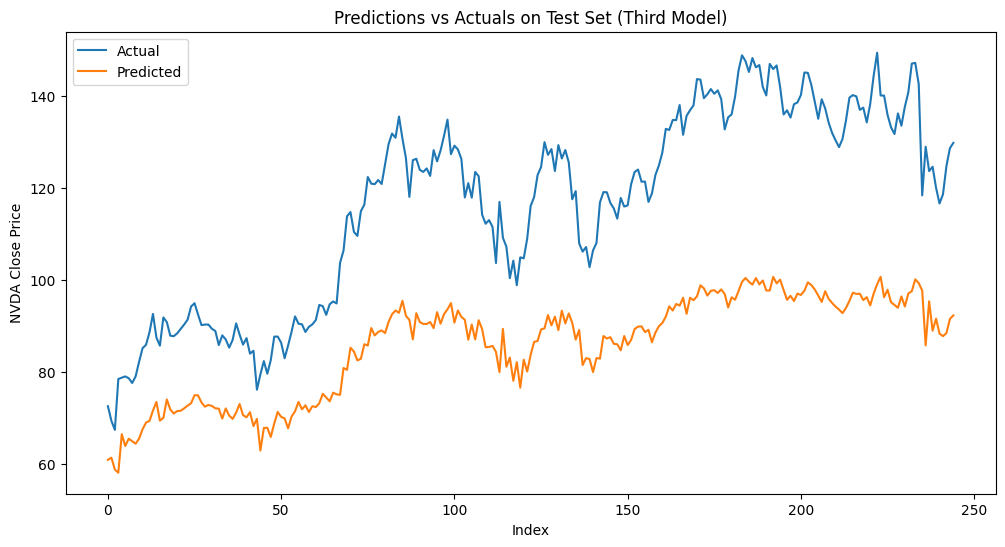

In [18]:
# Step 9: Denormalize and Visualize Predictions for Third Model
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm3 = denormalize(test_preds3, scaler3, target_column_index3)
test_actuals_denorm3 = denormalize(test_actuals3.reshape(-1, 1), scaler3, target_column_index3)

# Plot predictions vs actuals for Third Model
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm3, label='Actual')
plt.plot(test_preds_denorm3, label='Predicted')
plt.title('Predictions vs Actuals on Test Set (Third Model)')
plt.xlabel('Index')
plt.ylabel('NVDA Close Price')
plt.legend()
plt.show()

## 4. Evaluate and discuss your results, using appropriate performance metrics

In [19]:
# MSE for the different models
print(f'Mean Squared Error on Test Dataset Model 1: {mse:.6f}')
print(f'Mean Squared Error on Test Dataset Model 2 : {mse2:.6f}')
print(f'Mean Squared Error on Test Dataset Model 3: {mse3:.6f}')

Mean Squared Error on Test Dataset Model 1: 0.143380
Mean Squared Error on Test Dataset Model 2 : 0.065252
Mean Squared Error on Test Dataset Model 3: 0.050857


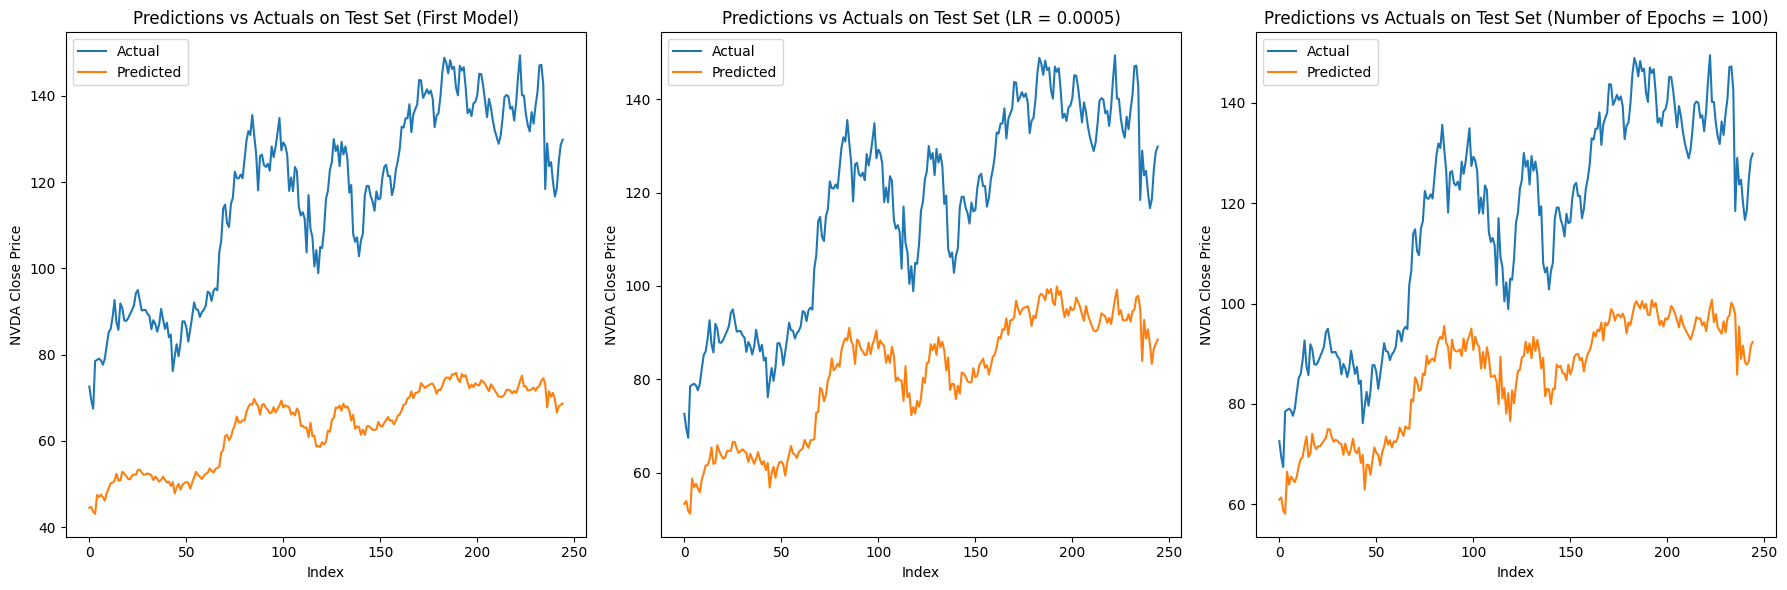

In [20]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns for side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First plot
axes[0].plot(test_actuals_denorm, label='Actual')
axes[0].plot(test_preds_denorm, label='Predicted')
axes[0].set_title('Predictions vs Actuals on Test Set (First Model)')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('NVDA Close Price')
axes[0].legend()

# Second plot
axes[1].plot(test_actuals_denorm2, label='Actual')
axes[1].plot(test_preds_denorm2, label='Predicted')
axes[1].set_title('Predictions vs Actuals on Test Set (LR = 0.0005)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('NVDA Close Price')
axes[1].legend()

# Third plot
axes[2].plot(test_actuals_denorm3, label='Actual')
axes[2].plot(test_preds_denorm3, label='Predicted')
axes[2].set_title('Predictions vs Actuals on Test Set (Number of Epochs = 100)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('NVDA Close Price')
axes[2].legend()

# Show the combined plots
plt.tight_layout()
plt.show()
